In [2]:
import pandas as pd
import tensorflow as tf

In [3]:
train = pd.read_csv("/Users/harika/Downloads/Data/entire_data.tsv", delimiter="\t")  # imdb data file

In [4]:
train.head(3)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...


In [5]:
train['review'].iloc[1]

'\\The Classic War of the Worlds\\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells\' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \\"critics\\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \\"critics\\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells\' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \\"critics\\" perceive to be its shortcomings."'

# Cleaning the data

In [6]:
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))



def general_clean(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z0-9.\- ]"," ",text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    text = text.strip()
    return text

In [7]:
train_clean= train['review'].apply(lambda x:general_clean(x))

In [8]:
train_clean.head(3)

0    with all this stuff going down at the moment w...
1    the classic war of the worlds by timothy hines...
2    the film starts with a manager nicholas bell g...
Name: review, dtype: object

In [9]:
train['cleaned_review']=train['review'].apply(lambda x:general_clean(x))


In [10]:
train.head(3)

,id,sentiment,review,cleaned_review
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hines...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...


# creating an average length of words

In [11]:
train['len']=train['cleaned_review'].apply(lambda x:len(x.split()))

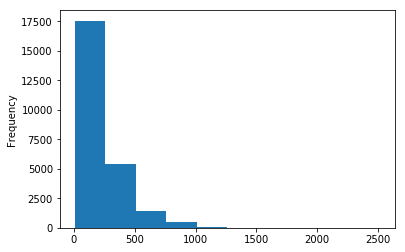

In [12]:
import matplotlib.pyplot as plot
train['len'].plot(kind="hist");

In [12]:
# most of the documents have 250 words hence i am taking 250 as my max_len
max_len=250

# creating sentences

In [13]:
train.head(3)

,id,sentiment,review,cleaned_review,len
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...,446
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hines...,160
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...,382


In [14]:
train=train[train['len']<=250]   # consider review only for words less than 250
train=train[train['len']>=10]    # reviews should have atleast 10 words

In [15]:
len(train)  # Hence i have 17000 reviews which have nearly 250 words in each of them

17067

# creating word embeddings for cleaned review

In [17]:
import numpy as np
def loadGloveModel(gloveFile):
    print "Loading Glove Model"
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print "Done.",len(model)," words loaded!"
    return model

model = loadGloveModel("/Users/harika/Downloads/glove.6B/glove.6B.50d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [18]:
model['this']

array([ 5.3074e-01,  4.0117e-01, -4.0785e-01,  1.5444e-01,  4.7782e-01,
        2.0754e-01, -2.6951e-01, -3.4023e-01, -1.0879e-01,  1.0563e-01,
       -1.0289e-01,  1.0849e-01, -4.9681e-01, -2.5128e-01,  8.4025e-01,
        3.8949e-01,  3.2284e-01, -2.2797e-01, -4.4342e-01, -3.1649e-01,
       -1.2406e-01, -2.8170e-01,  1.9467e-01,  5.5513e-02,  5.6705e-01,
       -1.7419e+00, -9.1145e-01,  2.7036e-01,  4.1927e-01,  2.0279e-02,
        4.0405e+00, -2.4943e-01, -2.0416e-01, -6.2762e-01, -5.4783e-02,
       -2.6883e-01,  1.8444e-01,  1.8204e-01, -2.3536e-01, -1.6155e-01,
       -2.7655e-01,  3.5506e-02, -3.8211e-01, -7.5134e-04, -2.4822e-01,
        2.8164e-01,  1.2819e-01,  2.8762e-01,  1.4440e-01,  2.3611e-01])

In [19]:
np.random.seed(0)
unk = list(np.random.uniform(low=-1.0, high=1.0, size=(50,)))  # unknown word vector
pad= list(np.zeros(50,dtype=float))  # zero padding

# adding pads if length is less than max review length and cutting if the length is more

In [21]:
from nltk.tokenize import word_tokenize

def sentence_embeddings(reviews):
    words=word_tokenize(reviews)
    words=[word.lower() for word in words]
    vec_sen=[list(model[word]) if word in model else unk for word in words]  # if word is not present append unknown vector
    if len(vec_sen)<max_len:          # if vector length is less add pading with zeros
        num_pads=max_len-len(vec_sen)   
        added_pads=[pad]*num_pads    
        added_pads.extend(vec_sen) 
        vec_sen = added_pads
    else:
        vec_sen=vec_sen[0:max_len]
         
        
    return (vec_sen) 

In [22]:
train['word_embeddings']=train['cleaned_review'].apply(lambda x:sentence_embeddings(x))

In [23]:
train['word_embeddings'].iloc[1][::-1]

[[-0.24553,
  0.92887,
  0.94636,
  0.29393,
  0.39314,
  0.53382,
  -0.29355,
  -0.31434,
  -0.62094,
  -0.4273,
  -0.23509,
  -0.52062,
  -0.095535,
  -0.3516,
  0.89212,
  -0.54079,
  -0.67408,
  -0.27857,
  -1.5973,
  0.38972,
  0.44949,
  -0.58631,
  1.1934,
  0.21847,
  -0.52188,
  -0.4662,
  0.80966,
  -0.61973,
  0.27912,
  -0.25251,
  3.5053,
  0.27438,
  -0.17765,
  0.68347,
  0.45855,
  -0.46349,
  0.6654,
  0.20135,
  0.5917,
  -0.44234,
  0.23723,
  -0.40514,
  0.70945,
  -0.95255,
  -0.55746,
  0.91859,
  0.17705,
  -0.75177,
  0.42187,
  0.48225],
 [-0.35209,
  0.82956,
  0.80144,
  0.48082,
  0.46673,
  0.63659,
  -0.26424,
  -0.30305,
  -0.72852,
  -0.52154,
  -0.17715,
  -0.53938,
  -0.23303,
  -0.26814,
  0.72069,
  -0.66766,
  -0.60444,
  -0.2251,
  -1.681,
  0.42743,
  0.38901,
  -0.6295,
  1.3271,
  0.37583,
  -0.58972,
  -0.40539,
  0.90764,
  -0.61069,
  0.37251,
  -0.34913,
  3.4705,
  0.1807,
  -0.35839,
  0.65343,
  0.35501,
  -0.37921,
  0.69662,
  0.25318,


In [24]:
train.head(3)

,id,sentiment,review,cleaned_review,len,word_embeddings
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hines...,160,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,8196_8,1,I dont know why people think this is such a ba...,i dont know why people think this is such a ba...,90,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,7166_2,0,"This movie could have been very good, but come...",this movie could have been very good but comes...,113,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [25]:
# train['word_embeddings'] = train.word_embeddings.apply(lambda x: np.array(x))

In [26]:
word_embeddings=list(train['word_embeddings'])

In [27]:
word_embeddings[0]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.

In [28]:
len(word_embeddings)   # total word embedding

17067

In [29]:
len(word_embeddings[0])    # 250 words

250

In [30]:
len(word_embeddings[0][0]) # each word having 50 dimensional vector

50

In [31]:
import numpy as np
def batch(x,y,batch_size):
#     print type(x[0])
    num_of_batches=len(x)//batch_size
    for i in range(0,len(x),batch_size):
        yield list(x[i:i+batch_size]),[[1,0] if m ==1 else [0,1] for m in y[i:i+batch_size]]
        #yield list(x[i:i+batch_size]),[[m] for m in y[i:i+batch_size]]
        #yield np.array(x[i:i+batch_size]),[[m] for m in y[i:i+batch_size]]

In [32]:
#b=batch(train.iloc[:]['word_embeddings'],train.iloc[:]['sentiment'],32)

# FEED FORWARD PART

In [33]:
# parameter declartaion
tf.reset_default_graph()    # clear the graph before we start using
input_data=tf.placeholder(tf.float32,[None,None,50],name="input")   # input should be the shape of wordembeddings
label=tf.placeholder(tf.float32,[None,None],name="label")            # target 

In [34]:
num_of_units=250    # output of lstm 
num_layers=1        # currently single layer

In [35]:
with tf.variable_scope("LSTM"):
    lstm = tf.nn.rnn_cell.LSTMCell(num_of_units)   # pass the number of lstm units 
    output,state = tf.nn.dynamic_rnn(lstm,input_data,dtype=tf.float32)   # output of each cell and previous state will be returned
    output_ = output[:,-1]                                              # consider final cell complete sentence reprsentation
    hid = tf.contrib.layers.fully_connected(output_, num_outputs = 90, activation_fn=tf.sigmoid)
    hid2 = tf.contrib.layers.fully_connected(output_, num_outputs = 45, activation_fn=tf.sigmoid)
    predictions = tf.contrib.layers.fully_connected(hid2, num_outputs = 2, activation_fn=tf.sigmoid)  # final output layer having two neurons one for positive one for negative
    loss = tf.losses.mean_squared_error(label, predictions)
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), label)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    

In [36]:
validation = train.sample(1000)   # taking 1000 samples for validation

In [37]:
validation.head(2)

,id,sentiment,review,cleaned_review,len,word_embeddings
23438,11015_9,1,This movie is directed by Renny Harlin the fin...,this movie is directed by renny harlin the fin...,128,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
13262,8289_4,0,"I'm sorry, but this is such a bad movie it's h...",i m sorry but this is such a bad movie it s hi...,153,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [38]:
len(train)

17067

In [39]:
train = (train[~train.id.isin(validation['id'])])   # remove validation samples from training data

In [40]:
print "Training samples :",len(train)
print "Validation samples :",len(validation)

Training samples : 16067
Validation samples : 1000


In [42]:
sentence = "this movie is awesome"
test_x = [sentence_embeddings(sentence)]    # test sentence

In [43]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for i in range(50):
        epoch_accuracy = 0
        batch_accuracy = 0
        batch_counter = 0
        for x,y in batch(train.iloc[:]['word_embeddings'],train.iloc[:]['sentiment'],250):
            tens_res = sess.run([output,output_,predictions,loss,optimizer,accuracy],feed_dict={input_data:x,label:y})
            batch_accuracy += tens_res[5]
            batch_counter = batch_counter + 1
            
        print "Epoch ",i
        print "Training accuracy :",batch_accuracy/batch_counter
        
#         #############################
#         validation_accuracy = 0
#         validation_counter =0 
#         for x,y in batch(validation.iloc[:]['word_embeddings'],validation.iloc[:]['sentiment'],250):
#             tens_res = sess.run([output,output_,predictions,loss,accuracy],feed_dict={input_data:x,label:y})
#             validation_accuracy+=tens_res[5]
#             validation_counter +=1
#         print "validation accuracy : ",validation_accuracy/validation_counter
#         #############################
        
        

        #############################
        for x,y in batch(validation.iloc[:]['word_embeddings'],validation.iloc[:]['sentiment'],1000):
            tens_res = sess.run([output,output_,predictions,accuracy],feed_dict={input_data:x,label:y})
            print "validation accuracy : ",tens_res[3]
        #############################
        
        
        print sess.run([predictions],feed_dict={input_data:test_x})
        print "---------------------------------------------"
#         res = tens_res[0]
#         print "Total number of samples' results :",len(res)   # number of batches specified
#         print "\nprinting LSTM output result for first sample :"
#         print res[0]
#         print '\nFirst sample had 250 words'
#         print "\nLSTM output for first word:",res[0][0]
#         print "\nLSTM output for last word:",res[0][-1]
#         print "\nLSTM output size fpr all words:",len(res[0][-1])
        
#         res1 = tens_res[1]
#         print "\nLast vec:",res1[0]
        
#         predictions = tens_res[2]
#         print predictions
        
#         print "label:",y

#         loss=tens_res[3]
#         print "loss:",loss
#         break

    

Epoch  0
Training accuracy : 0.604907001898839
validation accuracy :  0.681
[array([[0.57007223, 0.40621972]], dtype=float32)]
---------------------------------------------
Epoch  1
Training accuracy : 0.7067807142551129
validation accuracy :  0.706
[array([[0.4765136, 0.4963179]], dtype=float32)]
---------------------------------------------
Epoch  2
Training accuracy : 0.7259026408195496
validation accuracy :  0.7715
[array([[0.5601308, 0.4220922]], dtype=float32)]
---------------------------------------------
Epoch  3
Training accuracy : 0.7419357015536382
validation accuracy :  0.6865
[array([[0.58101594, 0.40134415]], dtype=float32)]
---------------------------------------------
Epoch  4
Training accuracy : 0.7638622283935547
validation accuracy :  0.758
[array([[0.5434661 , 0.43795693]], dtype=float32)]
---------------------------------------------
Epoch  5
Training accuracy : 0.7830245696581327
validation accuracy :  0.8005
[array([[0.56352884, 0.4187171 ]], dtype=float32)]
----

Epoch  47
Training accuracy : 0.9720473051071167
validation accuracy :  0.8475
[array([[0.7764027 , 0.22808689]], dtype=float32)]
---------------------------------------------
Epoch  48
Training accuracy : 0.970892308308528
validation accuracy :  0.842
[array([[0.86534387, 0.13754705]], dtype=float32)]
---------------------------------------------
Epoch  49
Training accuracy : 0.973600003352532
validation accuracy :  0.8415
[array([[0.8216527 , 0.18057495]], dtype=float32)]
---------------------------------------------
